In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,recall_score,precision_score,accuracy_score,f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
df = fetch_ucirepo(id=468) 
  
# data (as pandas dataframes) 
X = df.data.features 
y = df.data.targets 


In [32]:
X_encoded = X.copy()
y_encoded = y.copy()

In [33]:
X_encoded["Weekend"] = X_encoded["Weekend"].astype(int)

In [34]:
print(X_encoded["Weekend"].dtype)

int64


In [35]:
le = LabelEncoder()
X_encoded["VisitorType"] = le.fit_transform(X_encoded["VisitorType"])

In [36]:
X_encoded = pd.get_dummies(X_encoded, columns=['Month'], drop_first=True)

In [40]:
print(X["TrafficType"].value_counts())

TrafficType
2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: count, dtype: int64


In [42]:
X_encoded[['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = X_encoded[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype(str)

In [44]:
X_encoded = pd.get_dummies(X_encoded, columns=['OperatingSystems', 'Browser', 'Region', 'TrafficType'], drop_first=True)

KeyError: "None of [Index(['OperatingSystems', 'Browser', 'Region', 'TrafficType'], dtype='object')] are in the [columns]"

In [45]:
y_encoded["Revenue"] = y_encoded["Revenue"].astype(int)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

In [51]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [69]:
model = XGBClassifier(
    use_label_encoder=False,  # avoid warning
    eval_metric='logloss',    # required to suppress warning about eval metric
    random_state=42
)

model.fit(X_train, y_train)

C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:32:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [70]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [71]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8880778588807786
Precision: 0.6612244897959184
Recall: 0.5664335664335665
F1 Score: 0.6101694915254238
ROC AUC: 0.9135932024483351
Confusion Matrix:
 [[2961  166]
 [ 248  324]]


In [73]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='xgboost')

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predict & evaluate best model
y_pred_best = best_model.predict(X_test)
y_pred_prob_best = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}
Accuracy: 0.8983509056501757
Precision: 0.7103004291845494
Recall: 0.5786713286713286
F1 Score: 0.6377649325626205
ROC AUC: 0.9278193424739636
Confusion Matrix:
 [[2992  135]
 [ 241  331]]


C:\Users\HP\AppData\Local\Temp\ipykernel_7524\3435371678.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df.head(20), x='Importance', y='Feature', palette='viridis')


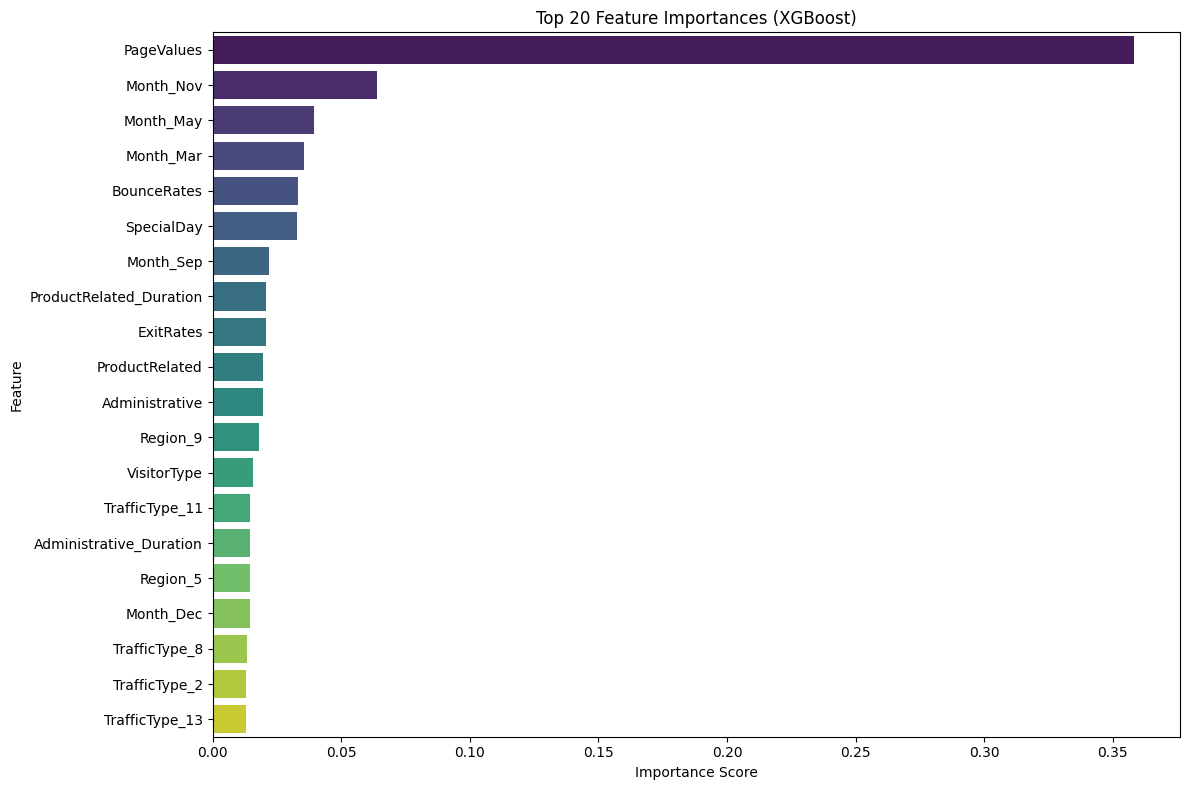

In [79]:
# Get feature importances from best model
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feat_df = feat_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=feat_df.head(20), x='Importance', y='Feature', palette='viridis')

plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()